# Basic statistical techniques and unsupervised learning

1. Clustering<br>
    1.1 K-Means clustering<br>
    1.2 Hierarchical clustering<br>
    1.3 Self-organizing maps<br>
    
2. Dimensionality reduction<br>
    2.1 PCA for data visualization<br>
    2.2 PCA for data pre-processing<br> 
3. Random-Forest classifiers 

### Import Python packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier

seed=42

### Custom utility functions

In [2]:
def plot_pca(X, components=[1, 2], figsize=(8, 6),
             color_vector=None, scale=False, title=None):
    """
    Apply PCA to input X.
    Args:
        color_vector : each element corresponds to a row in X. Unique elements are colored with a different color.

    Returns:
        pca : object of sklearn.decomposition.PCA()
        x_pca : pca matrix
        fig : PCA plot figure handle
    """
    if color_vector is not None:
        assert len(X) == len(color_vector), 'len(df) and len(color_vector) must be the same size.'
        n_colors = len(np.unique(color_vector))
        colors = iter(cm.rainbow(np.linspace(0, 1, n_colors)))

    X = pd.DataFrame(X)

    # PCA
    if scale:
        xx = StandardScaler().fit_transform(X.values)
    else:
        xx = X.values

    n_components = max(components)
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(xx)
    pc0 = components[0] - 1
    pc1 = components[1] - 1

    # Start plotting
    fig, ax = plt.subplots(figsize=figsize)
    alpha = 0.7

    if color_vector is not None:
        for color in np.unique(color_vector):
            idx = color_vector == color
            c = next(colors)
            ax.scatter(x_pca[idx, pc0], x_pca[idx, pc1], alpha=alpha,
                       marker='o', edgecolor=c, color=c,
                       label=f'{color}')
    else:
        ax.scatter(x_pca[:, pc0], x_pca[:, pc1], alpha=alpha,
                   marker='s', edgecolors=None, color='b')

    ax.set_xlabel('PC' + str(components[0]))
    ax.set_ylabel('PC' + str(components[1]))
    ax.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0), ncol=1, borderaxespad=0, frameon=True)
    plt.grid(True)
    if title:
        ax.set_title(title)

    print('Explained variance by PCA components [{}, {}]: [{:.5f}, {:.5f}]'.format(
        components[0], components[1],
        pca.explained_variance_ratio_[pc0],
        pca.explained_variance_ratio_[pc1]))

    return pca, x_pca


In [3]:
def load_cancer_data():
    """ Return cancer dataset (unscaled).
    Returns:
        X, Y
    """
    # Load data
    from sklearn import datasets
    data = datasets.load_breast_cancer()

    # Get features and target
    X = pd.DataFrame(data['data'], columns=data['feature_names'])
    X = X[sorted(X.columns)]
    Y = data['target']
    return X, Y

In [4]:
def plot_kmeans_obj(X_sc, tot_clusters=10):
    opt_obj_vec = []
    for k in range(1, tot_clusters):
        model = KMeans(n_clusters=k)  
        model.fit(X_sc)
        opt_obj_vec.append(model.inertia_/X_sc.shape[0])
        
    # Plot
    k = np.arange(len(opt_obj_vec)) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(k, opt_obj_vec, '--o')
    plt.xlabel('Number of clusters (k)', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.grid(True)
        
    return opt_obj_vec

In [5]:
def plot_hists(k_means_bins, y_bins, x_labels = ['Malignant', 'Benign']):
    """ Specific function to plot histograms from bins.
    matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """
    x = np.arange(len(x_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_bins, width, label='True label')
    rects2 = ax.bar(x + width/2, k_means_bins, width, label='K-means')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total count')
    ax.set_title('Histogram')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 450)

    def autolabel(rects):
        """ Attach a text label above each bar in *rects*, displaying its height. """
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    ax.legend(loc='best')

    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

In [6]:
# Related to SOM - finding best matching unit
def find_bmu(t, net, n):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(n, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(n, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

# Decaying radius of influence 
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

# Decaying learning rate
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

# Influence in 2D space
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

# Update weights
def update_weights(net,bmu_idx,r,l):
    wlen = net.shape[2]
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(wlen, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, wlen)
    return net

# 1. Clustering
Our objective is to segregate the dataset into discrete components representing low-dimensional structures that are not immediately visible. We will demonstrate this, first, on a toy dataset that we _design_ to have a lower inherent dimensionality.

### Toy dataset (2-D blobs)

In [7]:
n_samples = 300
n_features = 2
n_clusters = 3

X, y = datasets.make_blobs(n_samples = n_samples,
                           n_features = n_features,
                           centers = n_clusters,
                           random_state = seed)

In [8]:
# Normalize features
X_sc = StandardScaler().fit_transform(X)

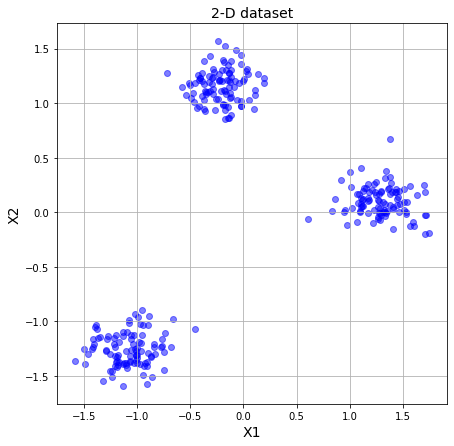

In [9]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(X_sc[:, 0], X_sc[:, 1], edgecolor=None, alpha=0.5, c='b');

plt.title('2-D dataset', fontsize=14)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.grid(True)

## 1.1 K-means Clustering

K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

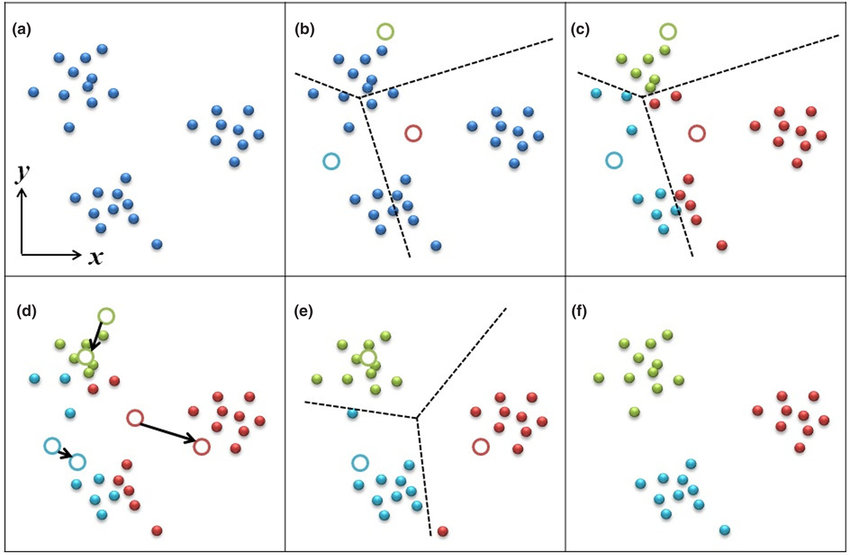

Figure courtesy Chen and Lai, 2018, Phys. Rev. E 97(3)

In [10]:
# Define k-means object
model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=seed, n_jobs=4)
# Train
model.fit(X_sc);

### Kmeans++ - Arthur and Vassilvitskii (2007) 
The exact algorithm is as follows (wikipedia):

1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
4. Repeat Steps 2 and 3 until k centers have been chosen.

In [11]:
# labels_ returns the labels for each sample
labels = model.labels_
print(np.bincount(labels))

[100 100 100]


In [12]:
# cluster_centers_ returns the coordinates of the centroids
centers = model.cluster_centers_
print(centers)

[[-0.21277029  1.15926337]
 [-1.07970061 -1.25787405]
 [ 1.2924709   0.09861068]]


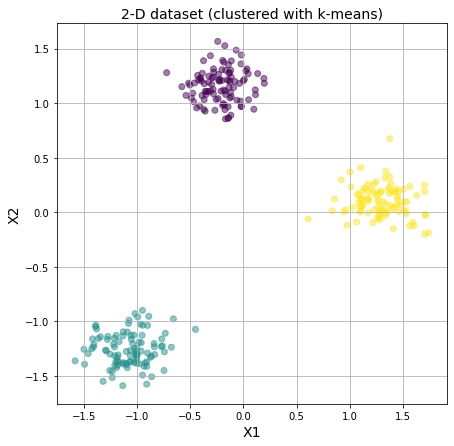

In [13]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(X_sc[:, 0], X_sc[:, 1], edgecolor=None, alpha=0.5, c=labels);

plt.title('2-D dataset (clustered with k-means)', fontsize=14)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.grid(True)

In [14]:
# Model inertia returns sum of squared distances of samples to their closest clusters
print(model.inertia_/X.shape[0])

0.060877197769653175


### How many *k* clusters to choose?
Inertia proves useful in assessing this - fit data with different _k_ and assess inertia. If inertia has _flatlined_ you've probably reached an indicative value of _k_

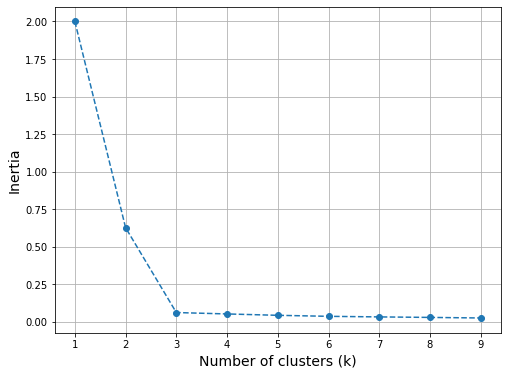

In [15]:
plot_kmeans_obj(X_sc, tot_clusters=10);

### Breast cancer dataset

In [16]:
# Load data
data = datasets.load_breast_cancer()
print(type(data))  # dictionary-like object
print(data.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [17]:
#print(data['DESCR'])  # README

In [18]:
# Get features and target
X = pd.DataFrame(data['data'], columns=data['feature_names'])
X = X[sorted(X.columns)]  # sort column by name

Y = pd.Series(data['target'])
Y = pd.Series(['Malignant' if v==0 else 'Benign' for v in Y.values]).astype('category') # convert to categorical

print(X.shape)
print(Y.shape)

(569, 30)
(569,)


In [19]:
display( X.iloc[:3,:7] )

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness
0,153.40,0.04904,0.01587,0.05373,0.006193,1001.0,0.27760
1,74.08,0.01308,0.01340,0.01860,0.003532,1326.0,0.07864
2,94.03,0.04006,0.02058,0.03832,0.004571,1203.0,0.15990


In [20]:
Y.value_counts()

Benign       357
Malignant    212
dtype: int64

In [21]:
# Scale features
scaler = StandardScaler()
scaler.fit(X)
X_sc = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [22]:
# Define K-means model
kmeans = KMeans(n_clusters=2)
# Train model
kmeans.fit(X_sc);

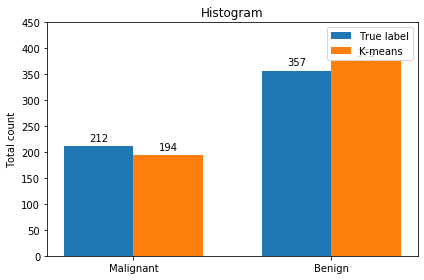

In [23]:
# Plot histogram of true class labels (malignant/benign) and cluster labels
k_means_bins = sorted(np.bincount(kmeans.labels_))
y_bins = sorted(Y.value_counts().values)
x_labels = ['Malignant', 'Benign']

plot_hists(k_means_bins, y_bins, x_labels=['Malignant', 'Benign'])

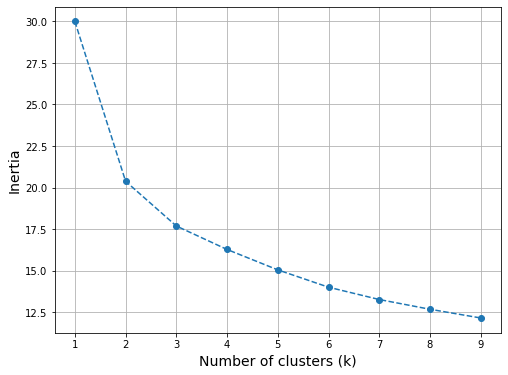

In [24]:
plot_kmeans_obj(X_sc, tot_clusters=10);

### Beware
In this case - we knew that 2 clusters (benign or malignant) were appropriate for our model. YMMV.

## 1.2 Hierarchical Clustering (agglomerative)
This technique uses a bottom-up approach were data points are _merged_ according to a distance metric. The result is a plot called a dendrogram which reveals underlying structure in your data as well.

In [25]:
# Get a random subset of cancer data
samples = 30
idx = np.random.choice(np.arange(X_sc.shape[0]), size=samples)

X_sc_sub = X_sc.iloc[idx, :].values
Y_sub = Y[idx].values

print(X_sc_sub.shape)
print(Y_sub.shape)
print(pd.Series(Y_sub).value_counts())

(30, 30)
(30,)
Benign       22
Malignant     8
dtype: int64


In [26]:
# Define hierarchical clustering model
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree='auto')
# Train model
model.fit(X_sc_sub);

### Linkage
Scikit-learn offers the following merging options
1. Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
2. Average linkage minimizes the average of the distances between all observations of pairs of clusters.
3. Single linkage minimizes the distance between the closest observations of pairs of clusters.
4. Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach. 

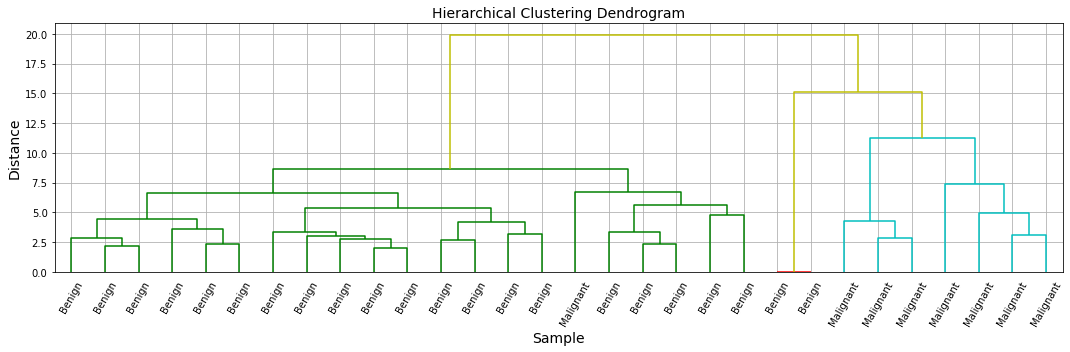

In [27]:
# We'll actually use a different module to plot the dendrogram
linkage_matrix = linkage(X_sc_sub, 'ward')

figure = plt.figure(figsize=(15, 5))
dendrogram(
    linkage_matrix,
    labels=Y_sub,
    leaf_rotation=60,
    above_threshold_color='y',
    color_threshold=12.5);

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

## 1.3 Self-organizing maps

Some of the concepts date back further, but SOMs were proposed and became widespread in the 1980s, by a Finnish professor named Teuvo Kohonen and are also called 'Kohonen maps'.

The idea behind a SOM is that you’re mapping high-dimensional vectors onto a smaller dimensional (typically 2D) space. Vectors that are close in the high-dimensional space also end up being mapped to nodes that are close in 2D space thus preserving the "topology" of the original data.

### Generating "Color" data and normalizing

In [28]:
raw_data = np.random.randint(0, 255, (200, 3))
data = StandardScaler().fit_transform(raw_data)

### Defining SOM 

In [29]:
network_dimensions = np.array([5, 5])
n_iterations = 2000
init_learning_rate = 0.01
# establish size variables based on data
m = data.shape[0]
n = data.shape[1]

# weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], n)) # 25 neurons each with a 3D vector

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

### Initial state of SOM color network

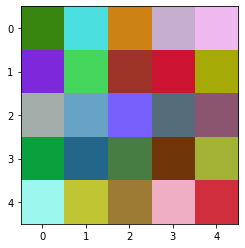

In [30]:
plt.imshow(net, interpolation='nearest')
plt.show()

### Training SOM

In [32]:
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = data[np.random.randint(0, m),:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n) # Gives the row, column of the best neuron
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)

### Visualization of trained colormap SOM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


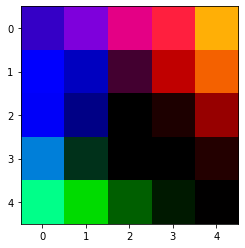

In [33]:
plt.imshow(net, interpolation='nearest')
plt.show()

### 1.3.5 SOM on Cancer data

In [35]:
# Load data
data = datasets.load_breast_cancer()
# Get features and target
X = pd.DataFrame(data['data'], columns=data['feature_names'])
X = X[sorted(X.columns)].to_numpy()  # sort column by name
Y = pd.Series(data['target']).to_numpy()

In [36]:
network_dimensions = np.array([10, 10])
n_iterations = 4000
init_learning_rate = 0.01
# establish size variables based on data
m = X.shape[0]
n = X.shape[1]

# weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], n))

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

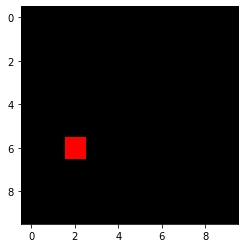

In [37]:
net_vis = np.zeros(shape=(np.shape(net)[0],np.shape(net)[1],3),dtype='double') # Array for SOM color map visualization

for sample in range(m):
    t = Xn[sample,:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n)
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample]
    
plt.imshow(net_vis)
plt.show()

### Training SOM on Cancer data

In [40]:
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = Xn[np.random.randint(0, m),:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n)
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)

### Visualization of trained SOM

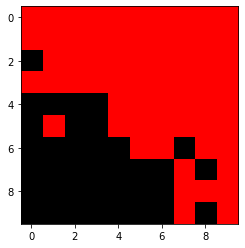

In [41]:
net_vis = np.zeros(shape=(np.shape(net)[0],np.shape(net)[1],3),dtype='double') # Array for SOM color map visualization

for sample in range(m):
    t = X[sample,:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n)
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign
    
plt.imshow(net_vis)
plt.show()

# 2. Dimensionality Reduction
Similar to k-means, PCA may also be used to reveal a lower dimensional representation of the data. This can prove to be useful since it is easier to visualize the data by _projecting_ on certain principal components.

In [42]:
# Load data
X, Y = load_cancer_data()
# Scale data
scaler = StandardScaler()
scaler.fit(X)
X_sc = pd.DataFrame( scaler.transform(X), columns=X.columns )

## 2.1. PCA for data visualization

In [43]:
# Find pairs of features with highest correlation
corr = X_sc.corr('pearson').values
np.fill_diagonal(corr, val=0) # in-place operation
corr = pd.DataFrame(corr, index=X_sc.columns, columns=X_sc.columns)

corr_th = 0.99
x_ids, y_ids = np.where(corr > corr_th) # find indices that satisfy the condition
    
display(corr.iloc[x_ids, y_ids])

,mean radius,mean perimeter,worst radius,worst perimeter
mean perimeter,0.997855,0.000000,0.969476,0.970387
mean radius,0.000000,0.997855,0.969539,0.965137
worst perimeter,0.965137,0.970387,0.993708,0.000000
worst radius,0.969539,0.969476,0.000000,0.993708


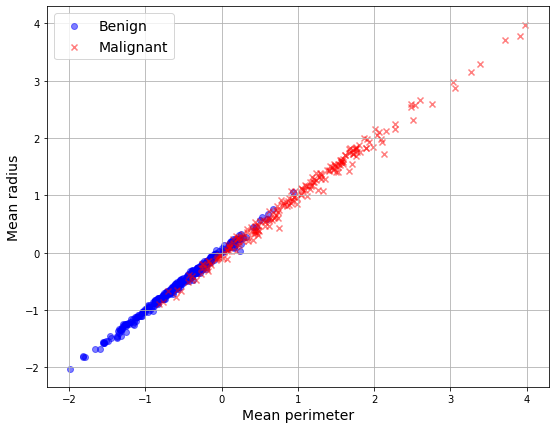

In [44]:
# Extract and plot two features with height correlation
x_2d = X_sc[['mean perimeter', 'mean radius']]

plt.figure(figsize=(9,7))

# plt.scatter(xtr['mean perimeter'], xtr['mean radius'], alpha=0.7, marker='o');
plt.scatter(x_2d.loc[Y==1, 'mean perimeter'],
            x_2d.loc[Y==1, 'mean radius'],
            alpha=0.5, marker='o', c='b', edgecolor=None, label='Benign');

plt.scatter(x_2d.loc[Y==0, 'mean perimeter'],
            x_2d.loc[Y==0, 'mean radius'],
            alpha=0.5, marker='x', c='r', edgecolor=None, label='Malignant');

plt.xlabel('Mean perimeter', fontsize=14)
plt.ylabel('Mean radius', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

In [45]:
# PCA with two highly correlated features
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2d) # compute PCA and return the result

# Print the proportion of explained variances
print(pca.explained_variance_ratio_)

[0.99892764 0.00107236]


Explained variance by PCA components [1, 2]: [0.99893, 0.00107]


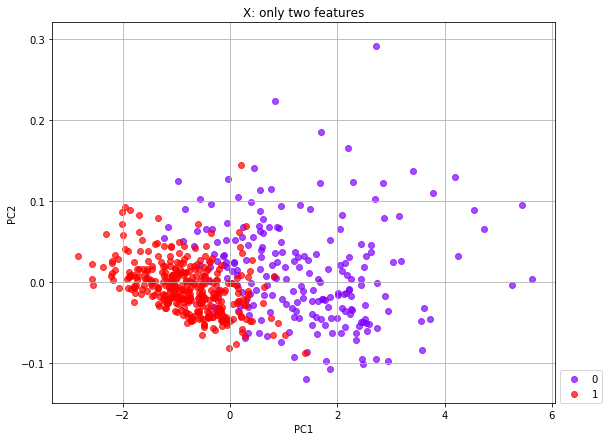

In [46]:
# Plot PCA
pca, _ = plot_pca( X=x_2d,
                   components=[1, 2],
                   color_vector=Y, title='X: only two features', figsize=(9,7) );

Explained variance by PCA components [1, 2]: [0.44272, 0.18971]


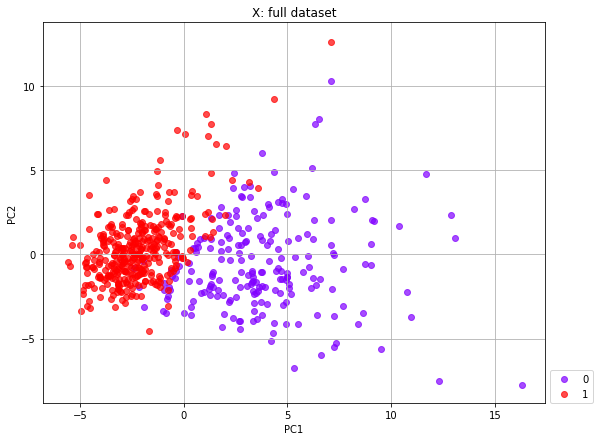

In [47]:
# Plot PCA of the full dataset
pca, _ = plot_pca( X=X_sc,
                   components=[1, 2],
                   color_vector=Y, title='X: full dataset', figsize=(9,7) );

## 2.2. PCA for data pre-processing

In [48]:
# Split dataset into train/test
xtr, xte, ytr, yte = train_test_split(X_sc, Y, test_size=0.2)

xtr.reset_index(drop=True, inplace=True)
xte.reset_index(drop=True, inplace=True)

print('X train shape:', xtr.shape)
print('X test shape: ', xte.shape)
print('Y train shape:', ytr.shape)
print('Y test shape: ', yte.shape)

X train shape: (455, 30)
X test shape:  (114, 30)
Y train shape: (455,)
Y test shape:  (114,)


In [49]:
# PCA xtr and xte
pca = PCA(n_components=xtr.shape[1])
xtr_pca = pca.fit_transform(xtr)  # PCA of the training set
xte_pca = pca.transform(xte)      # Apply the PCA transformation to the test set

print('X train PCA shape:', xtr_pca.shape)
print('X test PCA shape: ', xte_pca.shape)

X train PCA shape: (455, 30)
X test PCA shape:  (114, 30)


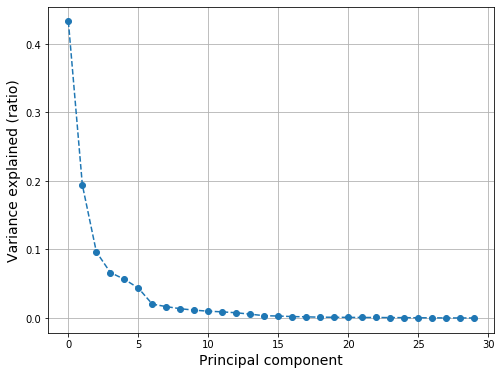

In [50]:
# Plot explained variance PCA
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, '--o')
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Variance explained (ratio)', fontsize=14)
plt.grid(True)

The features are highly redundant.

In [51]:
def pca_exp_var(pca, k):
    """ Print the total variance of the k principal components. """
    print (np.sum(pca.explained_variance_ratio_[:k]))

In [52]:
pca_exp_var(pca, k=10)

0.9519107924322595


# Random Forest Classifier

In [53]:
# Define Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, min_samples_split=5)
# Train Classifier
rf.fit(xtr, ytr);

In [40]:
# Predict on test set (inference)
y_pred = rf.predict(xte)
f1 = f1_score(yte, y_pred)
print('F1 score:', f1)

F1 score: 0.9705882352941176


### Random Forest Classifier with *K* PCA components

How many PCA components should we retain?
- You decide that you want to keep cetain amount of explained variance (e.g., 0.9, 0.95, 0.99).
- Look for the "elbow" in the explained variance plot.
- Use *k* as a hyperparameter (choose *k* that improves the generalization of your supervised learning model.

In [41]:
# Chooose how many PCA components to use
k = 17
pca_exp_var(pca, k=k)

0.9913557831344374


In [42]:
# Get the data for k PCA components
xtr_pca_sub = xtr_pca[:, :k]  # PCA of the training set
xte_pca_sub = xte_pca[:, :k]  # PCA of the test set

print(xtr_pca_sub.shape)
print(xte_pca_sub.shape)

(455, 17)
(114, 17)


In [43]:
# Define Random Forest Classifier
rf_pca = RandomForestClassifier(n_estimators=100, oob_score=True, min_samples_split=5)

# Train Classifier
rf_pca.fit(xtr_pca_sub, ytr);

In [44]:
y_pred = rf_pca.predict(xte_pca_sub)
f1 = f1_score(yte, y_pred)
print('F1 score:', f1)

F1 score: 0.9701492537313432


# Pilot1 cancer data

In [45]:
# Load data
df = pd.read_csv('rna.csv')

In [46]:
# Extract rna and meta
rna_cols = [c for c in df.columns if 'GE_' in c]
rna = df[rna_cols]
meta = df.drop(columns=['Unnamed: 0'] + rna_cols)

print(rna.shape)
print(meta.shape)

(28, 942)
(28, 4)


In [47]:
# Show features (gene expression)
display(rna.iloc[:3, :7])

,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6
0,-0.195763,-0.005649,-0.797589,-0.059784,1.030595,0.825662,-0.508877
1,-0.235008,-0.197465,0.500168,0.349134,-0.030125,0.929008,-0.828963
2,-0.444318,-0.492567,-0.315565,-0.477221,0.154885,0.055263,-0.901240


In [48]:
# Show meta data
display(meta[:3])

,sample,src,csite,ctype
0,GDC.PR_PRAD.TCGA_HC_7232_05454.p,gdc,prostate,Prostate Adenocarcinoma
1,GDC.LC_LUAD.TCGA_93_A4JN_03457.p,gdc,lung,Lung Adenocarcinoma
2,GDC.PR_PRAD.TCGA_ZG_A9LY_08904.p,gdc,prostate,Prostate Adenocarcinoma


In [49]:
col = 'csite'
meta[col].value_counts()

breast      7
lung        7
skin        7
prostate    7
Name: csite, dtype: int64

Explained variance by PCA components [1, 2]: [0.21882, 0.18155]


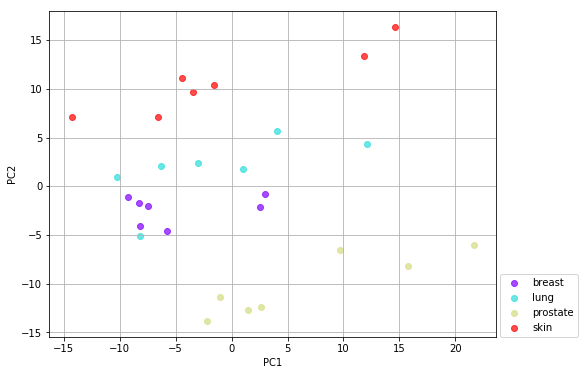

In [50]:
_, rna_pca = plot_pca(X=rna, components=[1,2], color_vector=meta[col])

### K-Means

In [51]:
n_clusters = 4

In [52]:
model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=seed, n_jobs=4)
model.fit(rna)

labels = model.labels_
print('Labels bincount:', np.bincount(labels))

Labels bincount: [ 5  5  8 10]


### Hierarchical Clustering

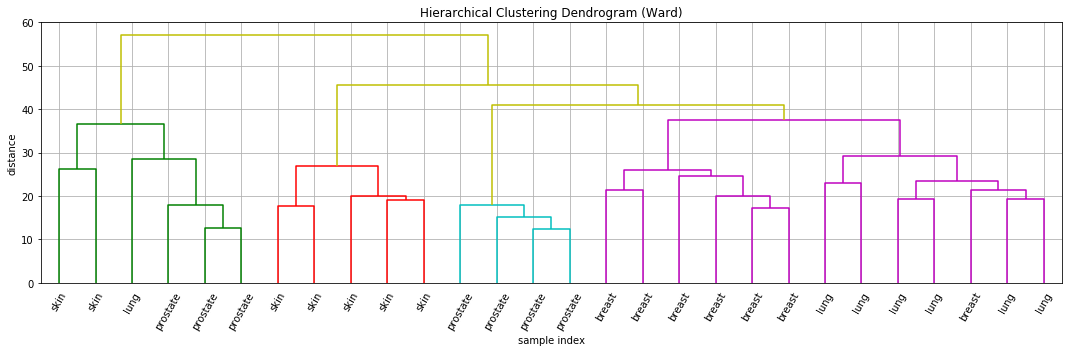

In [53]:
linkage_matrix = linkage(rna, 'ward')
figure = plt.figure(figsize=(15, 5))
dendrogram(
    linkage_matrix,
    color_threshold=40,
    labels=meta[col].values,
    leaf_rotation=60,
    show_contracted=True,
    above_threshold_color='y'
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.grid(True)
plt.show()

Hierarchical clustering makes it easier to find sub-populations in data.

# Keep learning

1. lagunita.stanford.edu/courses/HumanitiesSciences/StatLearning/Winter2016/course/
2. www.coursera.org/learn/ml-clustering-and-retrieval/
3. www.coursera.org/learn/machine-learning/home/week/8